In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
from matplotlib import rcParams
from peak_utils import *
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [2]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/merged_bed/MACS2/annotated'
peak_tsv = peak_path + '/unfragmented.annotated_peaks.tsv'
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype))
peak_df.head()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
0,chr14,50329265,50329578,unfragmented.rvs_peak_4777,1700938,29616.98633,170101.15625,170093.85938,62620.0,7SLRNA,misc RNA,-,.,Unannotated,0.0,0.0,Sense
1,chr5,140090856,140091005,unfragmented.fwd_peak_14339,1380011,24110.80273,138008.14062,138001.14062,39584.0,VTRNA1-1,misc RNA,+,.,Unannotated,0.0,0.0,Sense
2,chr14,50052918,50053619,unfragmented.fwd_peak_5178,684530,12476.17773,68458.88281,68453.03906,37916.0,7SLRNA,misc RNA,+,DDX24,RBP,0.0,0.0,Sense
3,chr1,28975111,28975251,unfragmented.fwd_peak_394,177427,3491.24731,17748.99219,17742.74414,7227.0,RNU11,snRNA,+,.,Unannotated,0.0,0.0,Sense
4,chr5,140098506,140098621,unfragmented.fwd_peak_14340,83422,1844.33948,8348.47754,8342.22559,2744.0,VTRNA1-2,misc RNA,+,.,Unannotated,0.0,0.0,Sense


In [3]:
peak_df.query('pileup >= 3').shape

(8688, 17)

In [4]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
random.seed(12)
colors = random.sample(colors, k = len(peak_df.sense_gtype.unique()))
ce.fit(peak_df.sense_gtype, colors)

peak_df\
        .assign(peak_count = 1)\
        .groupby(['sense_gtype', 'pileup'], as_index=False)\
        .agg({'peak_count':'sum'}) \
        .sort_values('pileup')\
        .reset_index() \
        .assign(cum_count = lambda d: d.groupby('sense_gtype').peak_count.cumsum())\
        .assign(log_pile = lambda d: d.pileup.transform(np.log10))\
        .query('sense_gtype == "Long RNA"')

In [5]:
peak_df.sense_gtype.unique()

array(['misc RNA', 'snRNA', 'Long RNA', 'Repeats', 'RBP', 'snoRNA',
       'miRNA', 'piRNA', 'Unannotated'], dtype=object)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_figure.pdf


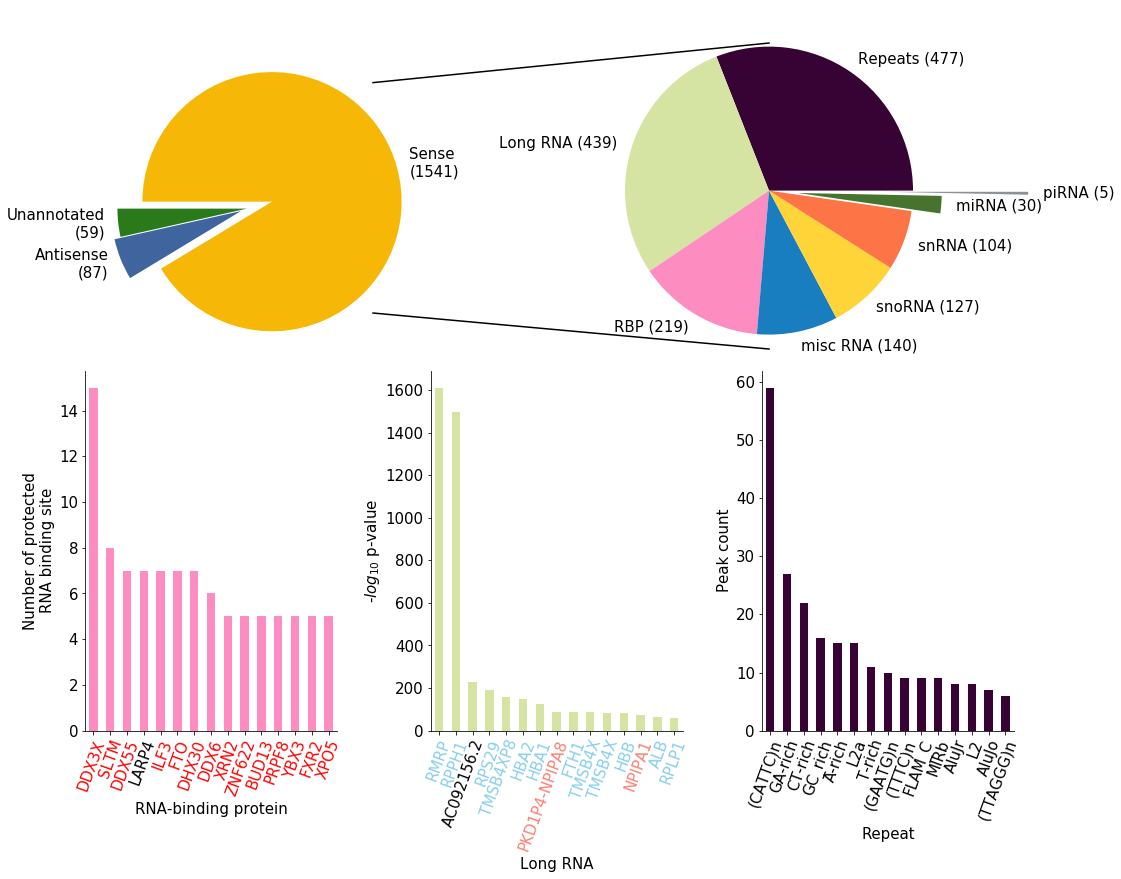

In [6]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n)
l1 = mlines.Line2D([0.3,0.85],[0.9,0.955], color= 'black',
                   figure = fig,  transform=fig.transFigure)
l2 = mlines.Line2D([0.3,0.85],[0.58,0.53], color= 'black',
                   figure = fig,  transform=fig.transFigure)
fig.lines.extend([l1, l2])
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [7]:
','.join(rbp_df.head(15).index)

'DDX3X,SLTM,DDX55,LARP4,ILF3,FTO,DHX30,DDX6,XRN2,ZNF622,BUD13,PRPF8,YBX3,FXR2,XPO5'

In [8]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


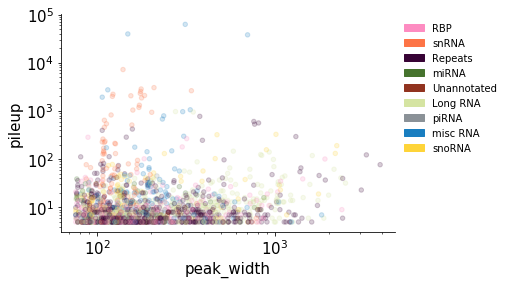

In [9]:
ax = plt.subplot()
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))\
    .plot.scatter('peak_width','pileup', 
                  color = ce.transform(peak_df.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


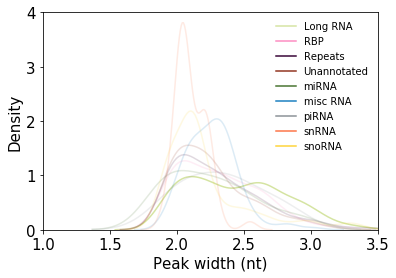

In [10]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: np.log10(d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 0.15
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width (nt)')

x_range = np.arange(1,4, 0.5)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_qc.pdf


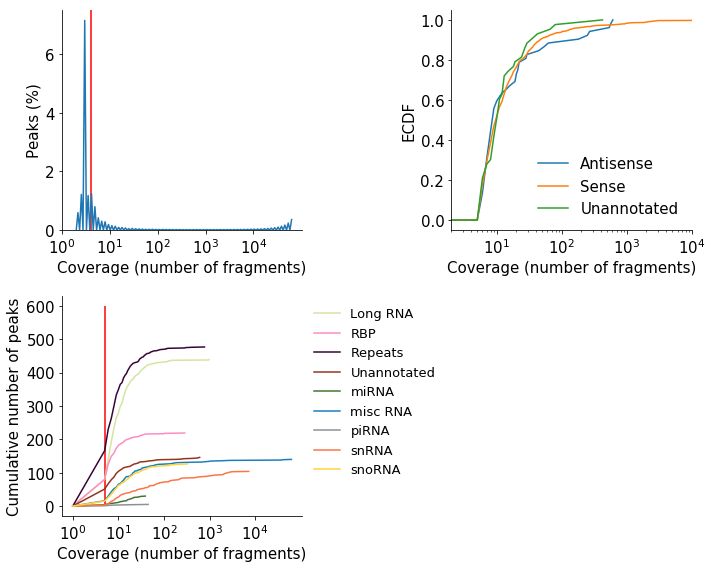

In [11]:
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peak_df, cov_ax)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)



In [12]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
25,chr9,35657742,35658018,unfragmented.rvs_peak_16066,16047,409.05945,1610.78271,1604.74451,973.0,RMRP,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
27,chr14,20811226,20811573,unfragmented.rvs_peak_4659,14901,389.61087,1496.17639,1490.16772,953.0,RPPH1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
53,chr2,140977638,140978003,unfragmented.rvs_peak_8956,2224,68.03314,227.72208,222.43318,88.0,AC092156.2,Long RNA,-,.,Unannotated,1.896357e-228,1.191631e-225,Sense
63,chr14,50052670,50053597,unfragmented.rvs_peak_4773,1846,65.38462,189.84077,184.64507,141.0,RPS29,Long RNA,-,RPS29,Long RNA,1.442879e-190,7.621330e-188,Sense
69,chr4,91759634,91760217,unfragmented.rvs_peak_12066,1541,49.16040,159.43649,154.18341,147.0,AC019188.1,Long RNA,-,CCSER1,Long RNA,3.660244e-160,1.755279e-157,Sense
71,chr16,222875,223705,unfragmented.fwd_peak_6263,1446,53.48116,150.08159,144.61230,125.0,HBA2,Long RNA,+,.,Unannotated,8.287242e-151,3.872267e-148,Sense
74,chr16,226679,227521,unfragmented.fwd_peak_6264,1195,45.17386,124.87024,119.52160,120.0,HBA1,Long RNA,+,.,Unannotated,1.348218e-125,5.992334e-123,Sense
93,chr16,16468913,16469003,unfragmented.fwd_peak_6429,841,33.14398,89.53519,84.12044,34.0,RP11-958N24.2,Long RNA,+,.,Unannotated,2.916151e-90,1.052297e-87,Sense
94,chr11,61734794,61735103,unfragmented.rvs_peak_2779,840,30.47960,89.32233,84.09661,57.0,FTH1,Long RNA,-,.,Unannotated,4.760691e-90,1.701060e-87,Sense
95,chrX,12994367,12995346,unfragmented.fwd_peak_18541,806,29.79177,85.82170,80.60618,99.0,TMSB4X,Long RNA,+,.,Unannotated,1.507648e-86,5.283437e-84,Sense


In [13]:
anti_peaks = peak_df.query('is_sense == "Antisense"')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_anti.pdf


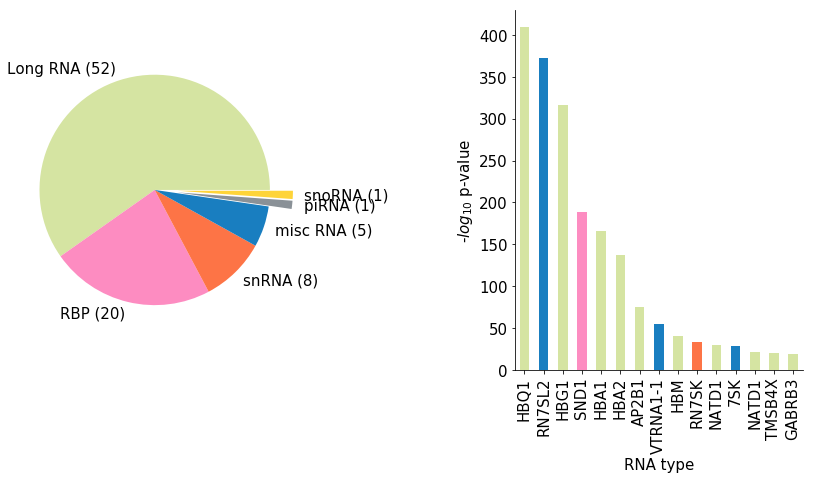

In [14]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0.1,0.4,0.8])
plot_peak_pie(anti_peaks, ax, ce, gtype='antisense_gtype')
ax = fig.add_axes([0.7, 0, 0.4, 1])
anti_plot = anti_peaks.head(15)
anti_plot.plot\
    .bar('antisense_gname', 'log10q', 
         color = ce.transform(anti_plot\
                               .antisense_gtype),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')
sns.despine()
fig.tight_layout()
figurename = figure_path + '/peak_anti.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [39]:
bam_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam'
ref_path = '/stor/work/Lambowitz/ref/hg19'
tracks = {'DNase I': bam_path + '/unfragmented.bam',
         'NaOH': bam_path + '/alkaline_hydrolysis.bam',
         'sncRNA': ref_path + '/new_genes/sncRNA_viz.bed',
         'Protein': ref_path + '/new_genes/genes.bed12.bed'}
genome = ref_path + '/genome/hg19_genome.fa'

def color_func(interval):
    return 'salmon' if get_strand(interval.read) == '+' else 'steelblue'

regions = 'chr14:50329268-50329569'
matches = re.search('(chr[0-9XY]+):([0-9]+)-([0-9]+)', regions)
chrom, start, end = matches.groups()

viz = genomeview.visualize_data(tracks, chrom, int(start)-400, int(end)+400, genome)
for track in ['DNase I', 'NaOH']:
    tr = genomeview.get_one_track(viz, track)
    tr.color_fn = color_func
    if track == "DNase I":
        tr.row_height = 0.02

viz

In [40]:
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
fa.fetch('chr12',22158771,22158870)

'TTTACCCAAATAAAGTATAGGTGATAGAAATTGTATCTTGACGCAATAGATATAGTACCGCAAGGGAAAGATGACAAAACATAACCAAGCATAAAATAG'

In [15]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df )\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-



(72, 23)

In [18]:
intron_df \
    .query('pileup >= 5' )

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,...,antisense_gtype,pvalue,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand
0,chr19,11333582,11333668,unfragmented.rvs_peak_7689,8779,245.78587,883.93384,877.97772,286.0,EFTUD2,...,Unannotated,0.000000e+00,0.000000e+00,Sense,chr19,11333582,11333668,ENSG00000130158.9,0,-
1,chr17,39913789,39913885,unfragmented.rvs_peak_6736,729,28.46350,78.24293,72.95807,30.0,XPO5,...,Unannotated,5.715708e-79,1.765379e-76,Sense,chr17,39913789,39913885,ENSG00000173801.12,0,-
2,chr16,2149772,2149861,unfragmented.rvs_peak_5807,714,28.12118,76.77870,71.48138,28.0,EFTUD2,...,Unannotated,1.664562e-77,4.853330e-75,Sense,chr16,2149772,2149861,ENSG00000008710.13,0,-
3,chr16,15027134,15027223,unfragmented.fwd_peak_6415,685,29.01322,73.82935,68.50440,30.0,RP11-958N24.1,...,Unannotated,1.481324e-74,4.185142e-72,Sense,chr16,15027134,15027223,ENSG00000183426.11,0,+
4,chr15,91423005,91423096,unfragmented.fwd_peak_6191,538,22.24964,59.07255,53.84354,23.0,XPO5,...,Unannotated,8.461551e-60,1.976857e-57,Sense,chr15,91423005,91423096,ENSG00000140564.6,0,+
5,chr16,18430618,18430707,unfragmented.rvs_peak_5936,530,22.59418,58.19377,53.00777,23.0,RP11-1212A22.1,...,Unannotated,6.400737e-59,1.485868e-56,Sense,chr16,18430618,18430707,ENSG00000214940.4,0,-
6,chr16,18470720,18470809,unfragmented.rvs_peak_5938,528,23.50634,58.07501,52.88714,24.0,RP11-1212A22.4,...,Unannotated,8.413758e-59,1.928603e-56,Sense,chr16,18470720,18470809,ENSG00000233024.3,0,-
7,chr16,16425621,16425710,unfragmented.fwd_peak_6427,498,22.37658,55.02792,49.81768,23.0,PKD1P1,...,Unannotated,9.377347e-56,2.071314e-53,Sense,chr16,16425621,16425710,ENSG00000183889.8,0,+
8,chr17,73500562,73500652,unfragmented.rvs_peak_6994,370,16.85889,42.08210,37.03542,17.0,CASKIN2,...,Unannotated,8.277515e-43,1.390241e-40,Sense,chr17,73500562,73500652,ENSG00000177303.5,0,-
9,chr6,31323001,31323093,unfragmented.rvs_peak_13538,301,13.46616,35.08864,30.13632,16.0,MIR6891,...,Unannotated,8.153799e-36,1.100642e-33,Sense,chr6,31323001,31323093,ENSG00000234745.5,0,-


In [60]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []
fa = pysam.Fastafile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
def fetch_seq(chrom, start, end, strand):
    intron_seq = fa.fetch(chrom, start - 1, end)
    intron_seq = intron_seq if strand == "+" else reverse_complement(intron_seq)
    return intron_seq
    
    

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,...,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,seq,dinucleotide
0,chr19,11333582,11333668,unfragmented.rvs_peak_7689,8779,245.78587,883.93384,877.97772,286.0,EFTUD2,...,0.000000e+00,Sense,chr19,11333582,11333668,ENSG00000130158.9,0,-,GTAGGAGTGGGCGTGGGCAGGGTGGGCATGGCATGGATGGAAGGCG...,GT:AG
1,chr17,39913789,39913885,unfragmented.rvs_peak_6736,729,28.46350,78.24293,72.95807,30.0,XPO5,...,1.765379e-76,Sense,chr17,39913789,39913885,ENSG00000173801.12,0,-,GTGAGCTGGGGGAGGGCAGGAGGCTGGGTCCCACTCCCCCAGCCAC...,GT:AG
2,chr16,2149772,2149861,unfragmented.rvs_peak_5807,714,28.12118,76.77870,71.48138,28.0,EFTUD2,...,4.853330e-75,Sense,chr16,2149772,2149861,ENSG00000008710.13,0,-,GTGGGTGCCGTAGGGGTCGGGGCAGCCTCTTCCTGCCCAGCCCTTC...,GT:AG
3,chr16,15027134,15027223,unfragmented.fwd_peak_6415,685,29.01322,73.82935,68.50440,30.0,RP11-958N24.1,...,4.185142e-72,Sense,chr16,15027134,15027223,ENSG00000183426.11,0,+,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,GT:AG
4,chr15,91423005,91423096,unfragmented.fwd_peak_6191,538,22.24964,59.07255,53.84354,23.0,XPO5,...,1.976857e-57,Sense,chr15,91423005,91423096,ENSG00000140564.6,0,+,GTGAGGGCAGGCTGGCCCGGCAGGCTGGATGTGGAGTTAGGTAGAA...,GT:AG


In [63]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

Written:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/intron_table.csv


In [46]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,...,pvalue,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,length
count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: 'DataFrame' object has no attribute 'gid'

In [48]:
glist

NameError: name 'glist' is not defined

In [49]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



NameError: name 'glist' is not defined

NameError: name 'glist' is not defined

In [50]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

NameError: name 'peaks' is not defined

In [51]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

NameError: name 'peaks' is not defined

In [52]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

NameError: name 'peaks' is not defined

In [53]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

NameError: name 'peaks' is not defined

In [54]:
import gseapy as gsp

In [55]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

2018-09-09 18:07:22,999 Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-54e17a5d030f>", line 2, in <module>
    gene_sets = 'KEGG_2016')
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 953, in prerank
    pre.run()
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 432, in run
    gmt = self.load_gmt(gene_list=dat2.index.values, gmt=self.gene_sets)
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 93, in load_gmt
    genesets_dict = self.parse_gmt(gmt)
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 138, in parse_gmt
    return self._download_libraries(gmt)
  File "/stor/work/Lambowitz/cdw2854/src/min

KeyboardInterrupt: 

In [ ]:
res.res2d

'ACCACGGCCGTTGAACATATGTCACTGGGCAGGCAGTGCCTCTACTACTGGTAATGCTAGCGGTGATGTTTTTGGTAAACAAGCTGGGTAAGATTTGCCGAGTTCCTTTTACTGTTTGTAATCTTTCCTTAGAGCATACCTGTGTTGGATTAACAGTAT'

In [131]:
aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
aln = aligner.map(fa.fetch('chr17',33981908,33982067))

In [132]:
print(next(aln))

0	148	-	chrM	16569	2426	2575	135	149	40	tp:A:P	ts:A:.	cg:Z:17M1D131M


In [151]:
def check_MT(peaks, return_column=False):
    mt = 0
    aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
    fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
    mts = []
    for peak_count, row in peaks.reset_index().iterrows():
        seq = fa.fetch(row['chrom'], row['start'], row['end'])
        seq = seq if row['strand'] == "+" else reverse_complement(seq)
    
        alns = aligner.map(seq)
        try:
            aln = next(alns)
            mt += 1
            mts.append('MT')
            #print(aln.cigar_str)
        except StopIteration:
            #print(row)
            mts.append('no')
            pass


    print('%i seq: %i in MT' %(peak_count, mt))
    if return_column:
        return mts

In [152]:
anti = peak_df.query('pileup >= 3').query('is_sense == "Unannotated"')
anti['MT'] = check_MT(anti, return_column=True)

81 seq: 15 in MT


In [153]:
anti

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,MT
20728,chr2,227586984,227587141,unfragmented.fwd_peak_1459,2680,72.40152,273.75925,268.09518,140.0,.,Unannotated,+,.,Unannotated,1.740804e-274,9.337462e-272,Unannotated,MT
20734,chr1,222984896,222985170,unfragmented.rvs_peak_1826,349,12.01115,39.27505,34.95559,34.0,.,Unannotated,-,.,Unannotated,5.308233e-40,8.559282e-38,Unannotated,no
20736,chr2,140980295,140980497,unfragmented.rvs_peak_11378,222,10.04906,26.92017,22.27997,15.0,.,Unannotated,-,.,Unannotated,1.201794e-27,1.397644e-25,Unannotated,MT
20737,chr12,22158771,22158870,unfragmented.fwd_peak_526,220,9.36087,26.88462,22.03110,20.0,.,Unannotated,+,.,Unannotated,1.304308e-27,1.510181e-25,Unannotated,MT
20739,chr2,140979201,140979904,unfragmented.rvs_peak_11377,190,8.19589,23.65310,19.01147,18.0,.,Unannotated,-,.,Unannotated,2.222798e-24,2.238383e-22,Unannotated,MT
20740,chrX,44654061,44654138,unfragmented.fwd_peak_2734,177,8.12950,22.79857,17.77446,9.0,.,Unannotated,+,.,Unannotated,1.590120e-23,1.536512e-21,Unannotated,no
20741,chr2,132141886,132141956,unfragmented.fwd_peak_1381,170,7.93465,22.09520,17.06328,7.0,.,Unannotated,+,.,Unannotated,8.031562e-23,7.472888e-21,Unannotated,no
20745,chr14,84637707,84637775,unfragmented.fwd_peak_779,123,6.37077,17.28895,12.39725,6.0,.,Unannotated,+,.,Unannotated,5.141028e-18,3.732642e-16,Unannotated,no
20746,chr2,41012102,41012256,unfragmented.fwd_peak_1307,116,6.03993,16.41665,11.61104,9.0,.,Unannotated,+,.,Unannotated,3.831334e-17,2.511196e-15,Unannotated,MT
20747,chr14,84053909,84054201,unfragmented.rvs_peak_6518,113,5.78329,15.76567,11.37457,17.0,.,Unannotated,-,.,Unannotated,1.715260e-16,1.086318e-14,Unannotated,MT
